In [234]:
# import libraries
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from tqdm import tnrange, tqdm_notebook
from IPython import display
import time
import tensorflow as tf

import pypianoroll
from IPython.display import FileLink, FileLinks
from os import walk

from scipy.stats import normaltest

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import pandas as pd
import seaborn as sns

In [133]:
path = '/home/mjjdg/Documents/M1/Artifiicial and Natural Music Cognition/Assignment/data/classic_piano_train_4.npy'
sample = np.load(path)

We will attempt to split the melody from the underlying chords. First we load the data and convert it to a pypianoroll.

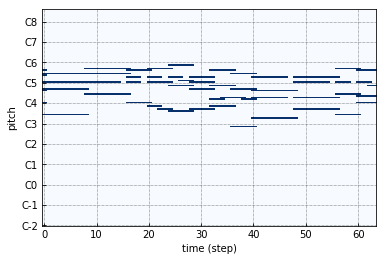

In [134]:
# Create a piano-roll matrix, where the first and second axes represent time and pitch, respectively
pianoroll = sample[:,:,0].astype(float)*128
#pianoroll = np.fliplr(pianoroll)

# Padd below
padded_pianoroll = np.hstack((np.zeros((64,44), dtype=float), pianoroll))

# Padd above
#padded_pianoroll = np.hstack((pianoroll, np.zeros((64,44), dtype=float)))

# Create a `pypianoroll.Track` instance
track = Track(pianoroll=padded_pianoroll, program=1, is_drum=False,
              name='Sample Classical')

# Plot the piano-roll
fig, ax = track.plot()
plt.show()

This function finds the active pitches in the piano roll and determines a split between melody/harmony using note duration.

In [135]:
# Heuristic: any pitch <= than a beat is part of the melody
def extract_melody(pianoroll, note_threshold=4):
    melody_pianoroll = np.zeros((64,128), dtype=float)
    chord_pianoroll = np.zeros((64,128), dtype=float)
    
    active_pitches = {}
    for ts in range(pianoroll.shape[0]):
        for ps in range(pianoroll.shape[1]):
            if pianoroll[ts,ps] != 0 and ps not in active_pitches:
                active_pitches[ps] = [[ts]]
            elif pianoroll[ts,ps] != 0 and (active_pitches[ps][-1][-1]+1 == ts):
                active_pitches[ps][-1].append(ts)
            elif pianoroll[ts,ps] != 0:
                active_pitches[ps].append([ts])

    for pitch, durations in active_pitches.items():
        for duration in durations:
            if(len(duration) <= note_threshold):
                for ts in duration:
                    melody_pianoroll[ts,pitch] = 128
            else:
                for ts in duration:
                    chord_pianoroll[ts,pitch] = 128
        
    return melody_pianoroll, chord_pianoroll

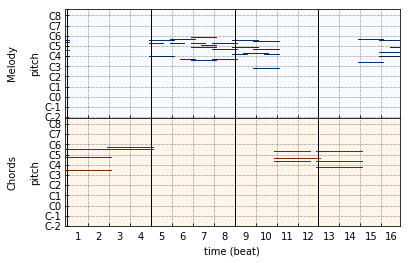

In [136]:
melody_pianoroll, chord_pianoroll = extract_melody(padded_pianoroll, 5)

# Create a `pypianoroll.Track` instance
melody = Track(pianoroll=melody_pianoroll, program=1, is_drum=False,
              name='Melody')
chords = Track(pianoroll=chord_pianoroll, program=1, is_drum=False,
              name='Chords')

# Create a `pypianoroll.Multitrack` instance in order to write as a MIDI file
multitrack = Multitrack(tracks=[melody, chords], tempo=120.0,
                        downbeat=[0,16,32,48], beat_resolution=4)

# Plot the multi-track piano-roll
fig, axs = multitrack.plot()
plt.show()

# Write the `pypianoroll.Multitrack` instance to a MIDI file
pypianoroll.write(multitrack,'./complete.mid')

In [137]:
multitrack = Multitrack(tracks=[chords, chords], tempo=120.0,
                        downbeat=[0,16,32,48], beat_resolution=4)

# Write the `pypianoroll.Multitrack` instance to a MIDI file
pypianoroll.write(multitrack,'./chords.mid')

multitrack = Multitrack(tracks=[melody, melody], tempo=120.0,
                        downbeat=[0,16,32,48], beat_resolution=4)

# Write the `pypianoroll.Multitrack` instance to a MIDI file
pypianoroll.write(multitrack,'./melody.mid')

Since splitting melody/harmony appears to be a dead end we implement a 'shallow description model' for the entire pianoroll.

According to https://grfia.dlsi.ua.es/repositori/grfia/pubs/130/icmc2004.pdf table 1 the following 12 features are usefull for style classification:

1. Number of notes
2. Pitch average
3. Pitch range
4. Interval range
5. Syncopation
6. Pitch deviation
7. Number of significant silences (we will use >= 16th note silence as significant)
8. Interval distrib. normality
9. Interval deviation
10. IOI deviation <- dropped due to no discernable consecutive notes
11. Note duration deviaton
12. Non-diatonic degrees dev. <- dropped due to no song key information

In [155]:
def extract_features(pianoroll):

    active_pitches = {}
    pitches = []
    intervals = []
    itvRNG = 0 # Interval range
    silsigNUM = 0 # Number of significant silences
    for ts in range(pianoroll.shape[0]):
        if sum(pianoroll[ts]) == 0:
            silsigNUM += 1
        for ps in range(pianoroll.shape[1]):
            if pianoroll[ts,ps] != 0 and ps not in active_pitches:
                pitches.append(ps)
                active_pitches[ps] = [[ts]]
            elif pianoroll[ts,ps] != 0 and (active_pitches[ps][-1][-1]+1 == ts):
                pitches.append(ps)
                active_pitches[ps][-1].append(ts)
            elif pianoroll[ts,ps] != 0:
                pitches.append(ps)
                active_pitches[ps].append([ts])
        if pitches:
            intervals.append((max(pitches)-min(pitches)))
            if intervals[-1] > itvRNG:
                itvRNG = (max(pitches)-min(pitches))
            pitches = []
    
    if len(intervals) >= 20: # D'Agostino's K-squared test only valid for n >= 20
        itvNORM, p = normaltest(intervals) # Interval distribution
    else:
        itvNORM = 0
        
    itvDEV = np.std(intervals) # Interval deviation
    
    notNUM = 0 # Number of notes
    pchRNG = max(active_pitches.keys())-min(active_pitches.keys()) # Pitch range
    syncop = 0 # Number of syncopations
    pitch_count = []
    note_durations = []
    for pitch, durations in active_pitches.items():
        notNUM += len(durations)
        for tss in durations:
            note_durations.append(len(tss))
            if tss[0]%4 != 0:
                syncop += 1
            for ts in tss:
                pitch_count.append(pitch)

    pchAVG = np.mean(pitch_count) # Pitch average
    pchDEV = np.std(pitch_count) # Pitch deviation
    durDEV = np.std(note_durations) # Note duration deviation
    
    return [notNUM, pchAVG, pchRNG, itvRNG, syncop, pchDEV, silsigNUM, itvNORM, itvDEV, durDEV]

In [156]:
features = extract_features(padded_pianoroll)
print(features)

[54, 79.9, 36, 33, 5, 8.99580361938947, 0, 1.5568676273323778, 4.534562366907638, 3.0809828656422846]


In [254]:
#Load datasets
cl_path = '/home/mjjdg/Documents/M1/Artifiicial and Natural Music Cognition/Assignment/data/Dataset (use directly)/JCP_mixed/'

f_cl = []
for (dirpath, dirnames, filenames) in walk(cl_path):
    f_cl.extend(filenames)
    break


f_cl_train, f_cl_test = train_test_split(f_cl, test_size=.1)
print('Using:',len(f_cl_test),'samples')
x_test = np.zeros((len(f_cl_test), 10))
y_test = np.empty(len(f_cl_test), dtype='str')

for i in range(len(f_cl_test)):
    full_path = os.path.join(cl_path,f_cl_test[i]) 
    sample = np.load(full_path)
    pianoroll = sample[:,:,0].astype(float)*128
    # Padd below
    x_test[i] = extract_features(np.hstack((np.zeros((64,44), dtype=float), pianoroll)))
    if 'jazz' in f_cl_test[i]:
        y_test[i] = 'j'
    elif 'classic' in f_cl_test[i]:
        y_test[i] = 'c'
    elif 'pop' in f_cl_test[i]:
        y_test[i] = 'p'
    else:
        y_test[i] = '?'

Using: 30284 samples


/home/mjjdg/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


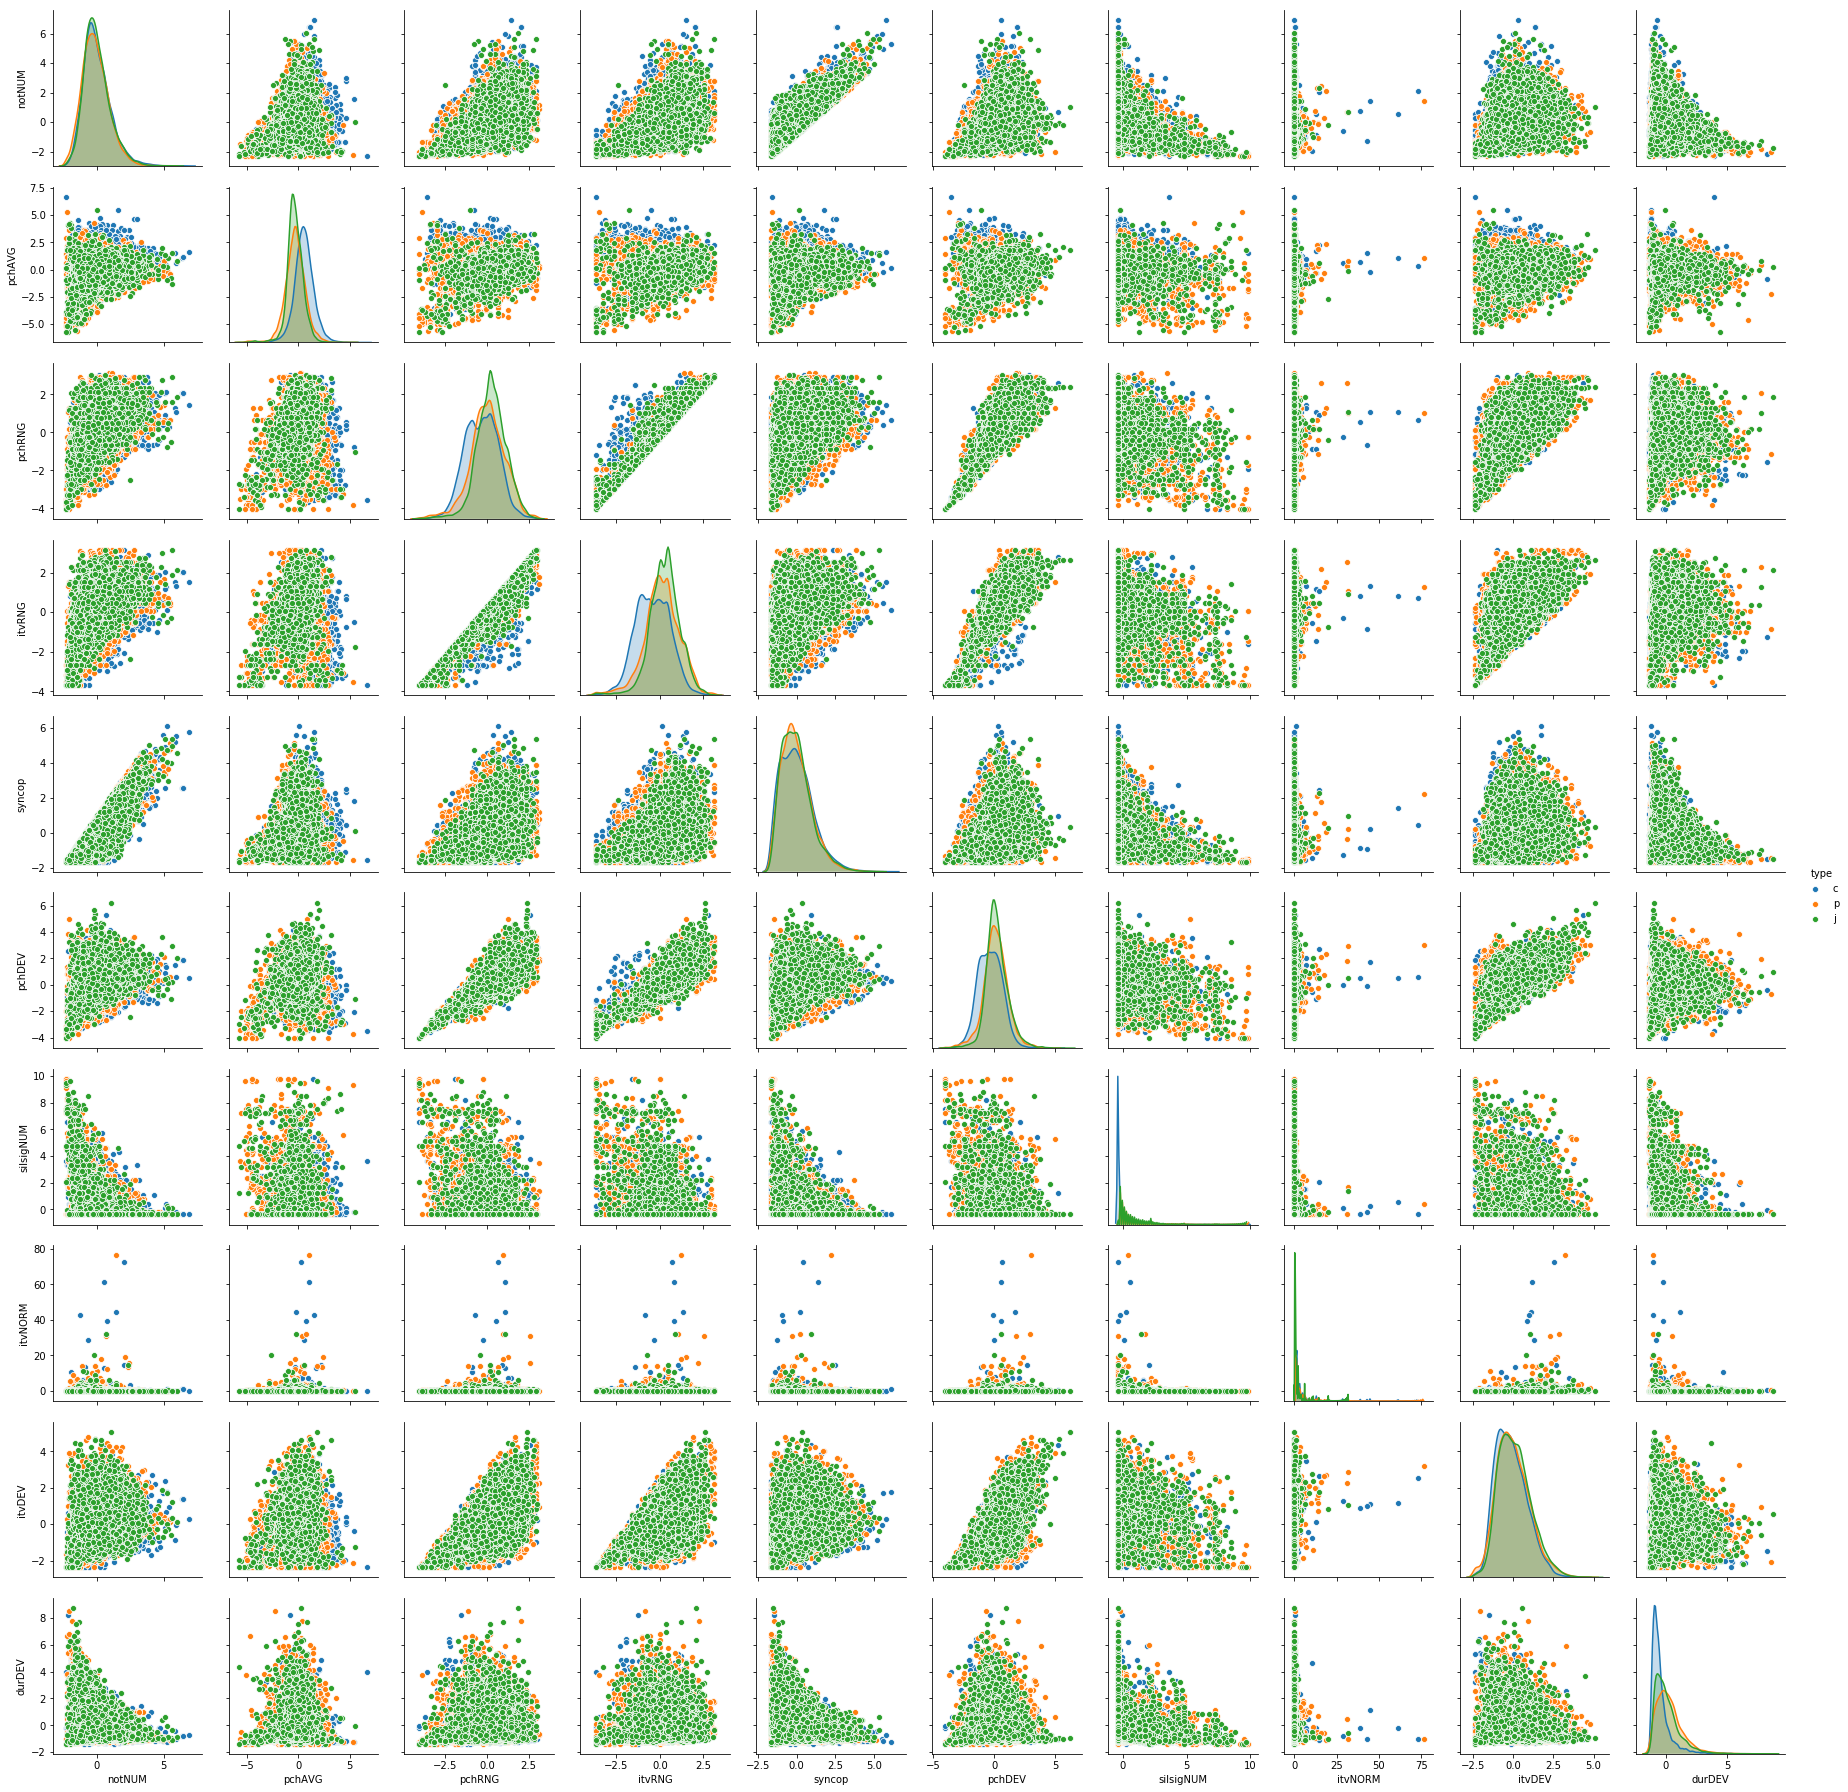

In [255]:
import pandas as pd
import seaborn as sns

x_test = StandardScaler().fit_transform(x_test)

data = pd.DataFrame({'type':y_test,'notNUM':x_test[:,0], 'pchAVG':x_test[:,1], 'pchRNG':x_test[:,2],
                    'itvRNG':x_test[:,3],'syncop':x_test[:,4],'pchDEV':x_test[:,5],'silsigNUM':x_test[:,6],
                    'itvNORM':x_test[:,7],'itvDEV':x_test[:,8],'durDEV':x_test[:,9]})

sns.pairplot(data, hue="type")

['c' 'p' 'j' ... 'p' 'c' 'c']


/home/mjjdg/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


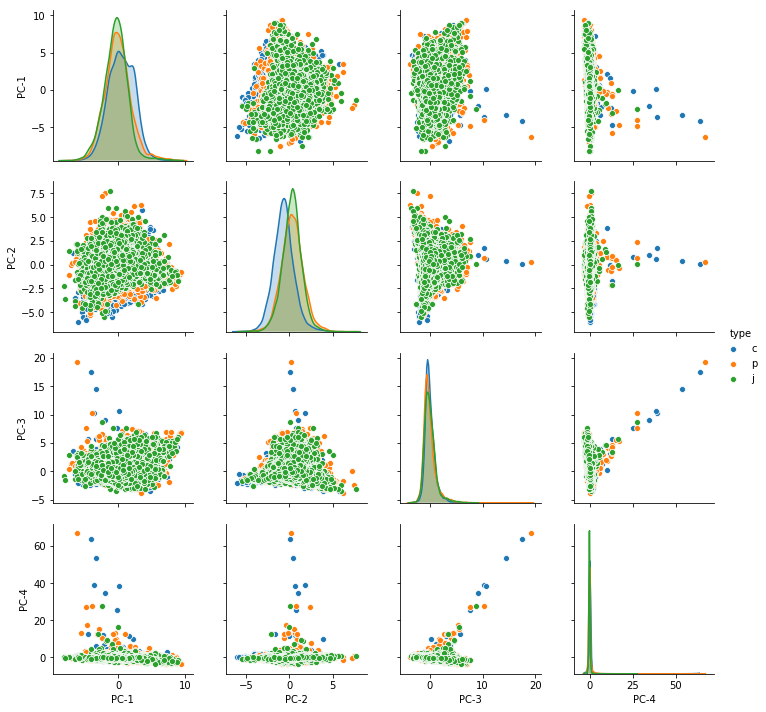

In [256]:
# PCA
print(y_test)

pca = PCA(n_components=4)

PCA_x = pca.fit_transform(x_test)

data = pd.DataFrame({'type':y_test,'PC-1':PCA_x[:,0], 'PC-2':PCA_x[:,1], 'PC-3':PCA_x[:,2],
                    'PC-4':PCA_x[:,3]})

sns.pairplot(data, hue="type")

In [257]:
print(x_test[0])
print(PCA_x[0])

[ 0.24375456  1.35523727  0.20372619  0.46578309 -0.50092693  0.67668876
 -0.37711399 -0.10224405 -0.88017203  0.81199266]
[-0.39553003  0.60623253 -1.10953744  0.59877573]
